# Experiments on backward variational ICA 

***Uncomment and run the following cell if you're using Collab***

In [1]:
# !rm -rf *
# !git clone https://github.com/mchagneux/backward_ica.git
# !mv backward_ica/* ./
# !rm -rf backward_ica

### Imports

In [2]:
from functools import partial
from src.elbo import linear_gaussian_elbo
from src.hmm import LinearGaussianHMM
from src import kalman
from jax.random import PRNGKey
import jax.numpy as jnp
import jax
import optax
from jax import random
from src.misc import *
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_debug_nans", True)
key = PRNGKey(0)
import matplotlib.pyplot as plt
# jax.config.update("jax_debug_nans",'True')
import numpy as np 
import pandas as pd
from IPython.display import display, Markdown, Latex

## Introduction

This notebook is comprised of a series of experiments that attempt to recover expectations $\mathbb{E}[h(z_{1:t})|x_{1:t}]$ via variational approximations, when the process $(z_t, x_t)_{t \ge 1}$ is an HMM. The main metric $\ell$ all along is the MSE against the true states when $h$ is a plain sum, ie

$$\ell = \left(\sum_{t=1}^T z_t^* - \sum_{t=1}^T \mathbb{E}_{q_T(z_t)}[z_t] \right)^2$$

where $q_T(z_t) = q(z_t|x_{1:T})$ is the marginal smoothing distribution at $t$.

In all the following, we assume that the variational smoothing distribution factorizes as $q_\phi(z_{1:t}|x_{1:t}) = q_\phi(z_t|x_{1:t}) \prod_{s=1}^{t-1} q_\phi(z_s|z_{s+1},x_{1:s})$. We always assume that $$q_\phi(z_t|x_{1:t}) \sim \mathcal{N}(\mu_{1:t}, \Sigma_{1:t})$$ and 

$$q_\phi(z_s|z_{s+1},x_{1:s}) \sim \mathcal{N}(\overleftarrow{\mu}_{1:t}(z_{s+1}), \overleftarrow{\Sigma}_{1:t})$$

In the following, we make several assumptions on both $p_\theta$ and $q_\phi$.

## 1. Linear Gaussian HMM 

First we assume that observation sequences $x_{1:T}$ arise from $p_\theta(z_{1:t},x_{1:t})$ defined as
$$z_t = A_\theta z_{t-1} + a_\theta + \eta_\theta$$ 
$$x_t = B_\theta z_t + b_\theta + \epsilon_\theta$$

where $\eta_\theta \sim \mathcal{N}(0,Q_\theta)$ and $\epsilon_\theta \sim \mathcal{N}(0,R_\theta)$

### 1. a. Approximated by a linear Gaussian HMM

We start by recovering $p_\theta$ when $q_\phi$ is in the family of the true $p_\theta$. We can do this by prescribing the model for $q_\phi$ in forward time with a similar HMM structure as $p_\theta$ (but random initial parameters), and in this case exceptionally, the parameters of the backward and filtering distributions are linked in closed-formed to the forward model via the Kalman filtering and smoothing recursions.

For this experiment, not only should the expectations be correctly recovered, but parameters in $\phi$ and $\theta$ may be identifiable in some cases (depending on the conditioning of $p_\theta$). We also know that in this case the best estimate of $z_{1:t}^*$ for any sequence is obtained via the Kalman smoothing recursions applied with the true parameters $\theta$ on the observations $x_{1:t}$, so we have an optimal estimator to compare to. 


#### Checking that $\mathcal{L}(\theta, \theta) = \log p_\theta$ 
*Remark: here $\log p$ is computed with Kalman*

In [3]:
state_dim, obs_dim = 2, 3
num_sequences = 30
length = 16
display(Markdown(f'Number of observations per sequence: {length}'))
display(Markdown(f'Number of sequences: {num_sequences}'))

key, *subkeys = random.split(key,3)

p_raw = LinearGaussianHMM.get_random_model(key=subkeys[0], state_dim=state_dim, obs_dim=obs_dim)

p = actual_model_from_raw_parameters(p_raw)

linear_gaussian_sampler = jax.vmap(LinearGaussianHMM.sample_joint_sequence, in_axes=(0, None, None))
key, *subkeys = random.split(key, num_sequences+1)
state_sequences, obs_sequences = linear_gaussian_sampler(jnp.array(subkeys), p, length)


filter_obs_sequences = jax.vmap(kalman.filter, in_axes=(0, None))
elbo_sequences = jax.jit(jax.vmap(linear_gaussian_elbo, in_axes=(None, None, 0)))

average_evidence_across_sequences = jnp.mean(filter_obs_sequences(obs_sequences, p)[-1])
display(Latex(f'Average $\log p_\\theta(x)$ across sequences $x$: {average_evidence_across_sequences:.2f}'))
average_elbo_across_sequences_with_true_model = jnp.mean(elbo_sequences(p_raw, p_raw, obs_sequences))
display(Latex('Average $|\mathcal{L}(\\theta,\\theta)- \log p_\\theta(x)|$ across sequences: ' + f'{jnp.abs(average_evidence_across_sequences-average_elbo_across_sequences_with_true_model):.2f}'))

Number of observations per sequence: 16

Number of sequences: 30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Optimizing $\phi$ when $\theta$ is fixed

In [4]:
def step(p_raw, q_raw, opt_state, batch):
    loss_value, grads = jax.value_and_grad(linear_gaussian_elbo, argnums=1)(p_raw, q_raw, batch)
    updates, opt_state = optimizer.update(grads, opt_state, q_raw)
    q_raw = optax.apply_updates(q_raw, updates)
    return p_raw, q_raw, opt_state, -loss_value
step = jax.jit(step)
q_raw = LinearGaussianHMM.get_random_model(key=subkeys[1], state_dim=state_dim, obs_dim=obs_dim)
average_elbo_across_sequences_with_init_q = jnp.mean(elbo_sequences(p_raw, q_raw, obs_sequences))
display(Latex('Average $|\mathcal{L}(\\theta,\\phi)- \log p_\\theta(x)|$ across sequences:' +  f'{jnp.abs(average_evidence_across_sequences-average_elbo_across_sequences_with_init_q):.2f}'))

<IPython.core.display.Latex object>

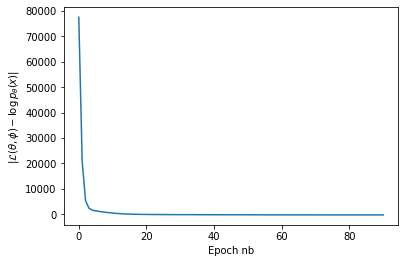

In [5]:
optimizer = optax.adam(learning_rate=-1e-3)

def fit(p_raw, q_raw, optimizer: optax.GradientTransformation) -> optax.Params:
    opt_state = optimizer.init(q_raw)

    eps = jnp.inf
    old_mean_epoch_elbo = -average_elbo_across_sequences_with_init_q
    epoch_nb = 0
    mean_elbos = [old_mean_epoch_elbo - average_evidence_across_sequences]
    while eps > 1e-2:
        epoch_elbo = 0.0
        for batch in obs_sequences: 
            p_raw, q_raw, opt_state, elbo_value = step(p_raw, q_raw, opt_state, batch)
            epoch_elbo += elbo_value
        mean_epoch_elbo = epoch_elbo/len(obs_sequences)
        eps = jnp.abs(mean_epoch_elbo - old_mean_epoch_elbo)
        epoch_nb+=1
        mean_elbos.append(mean_epoch_elbo - average_evidence_across_sequences)
        old_mean_epoch_elbo = mean_epoch_elbo
    return q_raw, mean_elbos


fitted_q_raw, mean_elbos = fit(p_raw, q_raw, optimizer)

plt.plot(mean_elbos)
plt.xlabel('Epoch nb'), 
plt.ylabel('$|\mathcal{L}(\\theta,\\phi)- \log p_\\theta(x)|$')
fitted_q = actual_model_from_raw_parameters(fitted_q_raw)

#### Computing expectations 


In [6]:
def squared_error_expectation_against_true_states(states, observations, approximate_linear_gaussian_model, additive_functional):
    smoothed_states, _ = kalman.smooth(observations, approximate_linear_gaussian_model)
    return jnp.sqrt((additive_functional(smoothed_states) - additive_functional(states)) ** 2)

additive_functional = partial(jnp.sum, axis=0)
mse_in_expectations = jax.vmap(squared_error_expectation_against_true_states, in_axes=(0,0, None, None))
print('MSE(E_q(h(z)), z_true):', jnp.mean(mse_in_expectations(state_sequences, obs_sequences, fitted_q, additive_functional), axis=0))
print('MSE(E_p(h(z)), z_true):', jnp.mean(mse_in_expectations(state_sequences, obs_sequences, p, additive_functional), axis=0))

MSE(E_q(h(z)), z_true): [0.0873562  0.08952309]
MSE(E_p(h(z)), z_true): [0.02279203 0.0420618 ]


#### Comparing values of $\phi$ and $\theta$

In [7]:
precision = 4
def convert_to_plain_python_dict(model):
    prior = {k: np.around(np.array(v),precision) for k,v in model.prior._asdict().items()}
    transition = {k: np.around(np.array(v),precision) for k,v in model.transition._asdict().items()}
    emission = {k: np.around(np.array(v),precision) for k,v in model.emission._asdict().items()}
    return {'prior':prior, 'transition':transition, 'emission':emission}
    

print('theta')
display(pd.DataFrame(convert_to_plain_python_dict(p)).T)
print('phi')
display(pd.DataFrame(convert_to_plain_python_dict(fitted_q)).T)


theta


,mean,cov,weight,bias
prior,"[0.0276, 0.0027]","[[0.0001, 0.0], [0.0, 0.0001]]",NaN,NaN
transition,NaN,"[[0.0001, 0.0], [0.0, 0.0001]]","[[0.1374, 0.0], [0.0, 0.6974]]","[0.2517, 0.6986]"
emission,NaN,"[[0.0001, 0.0, 0.0], [0.0, 0.0001, 0.0], [0.0,...","[[0.9776, 0.3334], [0.5715, 0.559], [0.0706, 0...","[0.1774, 0.86, 0.3161]"


phi


,mean,cov,weight,bias
prior,"[0.1327, 0.7465]","[[0.0, 0.0], [0.0, 0.0001]]",NaN,NaN
transition,NaN,"[[0.0001, 0.0], [0.0, 0.0]]","[[0.0121, 0.0], [0.0, 0.6924]]","[0.9035, 0.7358]"
emission,NaN,"[[0.0011, 0.0, 0.0], [0.0, 0.0004, 0.0], [0.0,...","[[0.2992, 0.9096], [0.1026, 0.9206], [0.6567, ...","[0.7979, 0.9539, 0.7919]"


*It seems that expectations are recovered quite well even though some parameters differ.*

### 1. b. Using a neural network to compute the backward parameters instead of Kalman recursions
We make the same assumptions on $p_\theta$ but now we attempt to recover the backward parameters via neural network.

*TODO*

## 2. A nonlinear emission p

We now assume that $p_\theta$ has a nonlinear emission distribution, ie. $x_t  = f_\theta(z_t) + \epsilon$.

### 2. a. Approximated by a linear Gaussian p.
We keep a linear gaussian distribution for $q_\phi$, but we add a mapping to compute the expectation of the emission term from $p_\theta$. We need to approximate the following quantity:

$$\mathbb{E}_{q(z_t|z_{t+1}, x_{1:t})}\left[(x_t - f_\theta(z_t))^T R^{{\theta}^{-1}}(x_t - f_\theta(z_t))\right]$$

And similarly for the last expectation under the filtering distribution: 

$$\mathbb{E}_{q(z_T|x_{1:T})}\left[(x_T - f_\theta(z_T))^T R^{{\theta}^{-1}}(x_T - f_\theta(z_T))\right]$$

#### 2. a. i. A sampling-free approach. 


If we know the expectation $\mu$ and variance $\Sigma$ of a random variable $v$ (which need not be Gaussian):

$$\mathbb{E}_{v}\left[(x - v)^T \Omega (x - v)\right] = tr(\Sigma \Omega) + (\mu - x)^T \Omega (\mu - x)$$

Suppose we a have neural network which approximates the mean and variance of $v \sim f_\theta(z)$ when $z \sim p_z$, given parameters of $p_z$. Denote $\tilde{\mu}$ and $\tilde{\Sigma}$ these means and variances estimated by this network. For the filtering case, we feed the network with filtering mean and covariance at $T$ to obtain an estimate of $\tilde{\mu}$ and $\tilde{\Sigma}$, then:

$$\mathbb{E}_{q(z_T|x_{1:T})}\left[(x_T - f_\theta(z_T))^T R^{{\theta}^{-1}}(x_T - f_\theta(z_T))\right] = tr(\tilde{\Sigma} \Omega) + (\tilde{\mu} - x)^T R^{{\theta}^{-1}} (\tilde{\mu} - x)$$

For the backwards case this is not as simple, because: $\overleftarrow{\mu}_{1:t}$ is a function of $z_{t+1}$, therefore $\mathbb{E}_{q(z_t|z_{t+1}, x_{1:t})}[f_\theta(z_t)]$ and $\mathbb{V}_{q(z_t|z_{t+1}, x_{1:t})}[f_\theta(z_t)]$ are also functions of $z_{t+1}$. 

We still attempt to use one network for both the fitlering and the backwards via the following scheme: 

- Build a neural network $g_\alpha(A, a, \Sigma)$ which outputs $\tilde{A}, \tilde{a}$ and $\tilde{\Sigma}$
- For the backwards case, use $A = \overleftarrow{A}_{1:t}, a = \overleftarrow{a}_{1:t}$ and $\Sigma = \overleftarrow{\Sigma}_{1:t}$, and consider that $\tilde{\mu} = \tilde{A}z_{t+1} + \tilde{a}$, while $\tilde{\Sigma}$ does not depend on $z_{t+1}$ (which is knowingly false). In this case, the quadratic form build for $\tilde{A}$ and $\tilde{a}$ is a quadratic form in $z_{t+1}$ as wanted.
- For the backwards case, use $A = 0, a = a_{1:t}$ and $\Sigma = \Sigma_{1:t}$, and consider that $\tilde{\mu} = \tilde{a}$ (without using the output $\tilde{A}$).

*This method, which is tried below: fails to learn anything as of now.*

In [8]:
### not reimplemented in JAX

#### 2. a. i. The Johnson trick
